# Module 3 - Programming Assignment

## Directions

1. Change the name of this file to be your JHED id as in `jsmith299.ipynb`. Because sure you use your JHED ID (it's made out of your name and not your student id which is just letters and numbers).
2. Make sure the notebook you submit is cleanly and fully executed. I do not grade unexecuted notebooks.
3. Submit your notebook back in Blackboard where you downloaded this file.

*Provide the output **exactly** as requested*

## k Nearest Neighbors and Model Evaluation

In this programming assignment you will use k Nearest Neighbors (kNN) to build a "model" that will estimate the compressive strength of various types of concrete. This assignment has several objectives:

1. Implement the kNN algorithm with k=9. Remember...the data + distance function is the model in kNN. In addition to asserts that unit test your code, you should "test drive" the model, showing output that a non-technical person could interpret.

2. You are going to compare the kNN model above against the baseline model described in the course notes (the mean of the training set's target variable). You should use 10 fold cross validation and Mean Squared Error (MSE):

$$MSE = \frac{1}{n}\sum^n_i (y_i - \hat{y}_i)^2$$

as the evaluation metric ("error"). Refer to the course notes for the format your output should take. Don't forget a discussion of the results.

3. use validation curves to tune a *hyperparameter* of the model. 
In this case, the hyperparameter is *k*, the number of neighbors. Don't forget a discussion of the results.

4. evaluate the *generalization error* of the new model.
Because you may have just created a new, better model, you need a sense of its generalization error, calculate that. Again, what would you like to see as output here? Refer to the course notes. Don't forget a discussion of the results. Did the new model do better than either model in Q2?

5. pick one of the "Choose Your Own Adventure" options.

Refer to the "course notes" for this module for most of this assignment.
Anytime you just need test/train split, use fold index 0 for the test set and the remainder as the training set.
Discuss any results.

## Load the Data

The function `parse_data` loads the data from the specified file and returns a List of Lists. The outer List is the data set and each element (List) is a specific observation. Each value of an observation is for a particular measurement. This is what we mean by "tidy" data.

The function also returns the *shuffled* data because the data might have been collected in a particular order that *might* bias training.

In [ ]:
%matplotlib inline
import random
from typing import List, Dict, Tuple, Callable
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [ ]:
def parse_data(file_name: str) -> List[List]:
    data = []
    file = open(file_name, "r")
    for line in file:
        datum = [float(value) for value in line.rstrip().split(",")]
        data.append(datum)
    random.shuffle(data)
    return data

In [ ]:
data = parse_data("concrete_compressive_strength.csv")

In [ ]:
data[0]

In [ ]:
len(data)

There are 1,030 observations and each observation has 8 measurements. The data dictionary for this data set tells us the definitions of the individual variables (columns/indices):

| Index | Variable | Definition |
|-------|----------|------------|
| 0     | cement   | kg in a cubic meter mixture |
| 1     | slag     | kg in a cubic meter mixture |
| 2     | ash      | kg in a cubic meter mixture |
| 3     | water    | kg in a cubic meter mixture |
| 4     | superplasticizer | kg in a cubic meter mixture |
| 5     | coarse aggregate | kg in a cubic meter mixture |
| 6     | fine aggregate | kg in a cubic meter mixture |
| 7     | age | days |
| 8     | concrete compressive strength | MPa |

The target ("y") variable is a Index 8, concrete compressive strength in (Mega?) [Pascals](https://en.wikipedia.org/wiki/Pascal_(unit)).

## Train/Test Splits - n folds

With n fold cross validation, we divide our data set into n subgroups called "folds" and then use those folds for training and testing. You pick n based on the size of your data set. If you have a small data set--100 observations--and you used n=10, each fold would only have 10 observations. That's probably too small. You want at least 30. At the other extreme, we generally don't use n > 10.

With 1,030 observations, n = 10 is fine so we will have 10 folds.
`create_folds` will take a list (xs) and split it into `n` equal folds with each fold containing one-tenth of the observations.

In [ ]:
def create_folds(xs: List, n: int) -> List[List[List]]:
    k, m = divmod(len(xs), n)
    # be careful of generators...
    return list(xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

In [ ]:
folds = create_folds(data, 10)

In [ ]:
len(folds)

We always use one of the n folds as a test set (and, sometimes, one of the folds as a *pruning* set but not for kNN), and the remaining folds as a training set.
We need a function that'll take our n folds and return the train and test sets:

In [ ]:
def create_train_test(folds: List[List[List]], index: int) -> Tuple[List[List], List[List]]:
    training = []
    test = []
    for i, fold in enumerate(folds):
        if i == index:
            test = fold
        else:
            training = training + fold
    return training, test

We can test the function to give us a train and test datasets where the test set is the fold at index 0:

In [ ]:
train, test = create_train_test(folds, 0)

In [ ]:
len(train)

In [ ]:
len(test)

## Answers

Answer the questions above in the space provided below, adding cells as you need to.
Put everything in the helper functions and document them.
Document everything (what you're doing and why).

<a id="euclidean_distance"></a>
## euclidean_distance

`euclidean_distance` this returns the euclidean distance between two rows, i.e their x's and y'(last indice in the row) **Used by**: [nearest_neighbors](#nearest_neighbors)

$$ d(x_1, x_2) = \sqrt{\sum_{i}(x_{1i} - x_{2i})^2} $$

* **row1** list: the first list of x,y values with y being the last value
* **row2** list: the second list of x,y values with y being the last value

**returns** float: the distance between the two points.

In [323]:
def euclidean_distance(row1:list, row2:list) -> float:
    distance = 0.0
    # length is subtracted by 1 since the last row is assumed to be the output column
    for index in range(len(row1) - 1):
        distance += (row1[index] - row2[index]) ** 2
    distance = distance ** 0.5
    return distance

In [324]:
test_row1 = [1, 2, 3]
test_row2 = [3, 4, 5]
assert euclidean_distance(test_row1, test_row2) == 2.8284271247461903

test_row3 =[1, 1, 1]
test_row4 =[1, 1, 1]
assert euclidean_distance(test_row3, test_row4) == 0

test_row5 =[1, 1, 1]
test_row6 =[0, 0, 0]

assert euclidean_distance(test_row5, test_row6) == 1.4142135623730951

<a id="nearest_neighbors"></a>
## nearest_neighbors

`nearest_neighbors` this uses the euclidean distance between the test row and the training data to return the nearest k amount of neighbors within the training data relative to the testing row **Used by**: [knn](#knn)

* **training_data** list [list] : all the points that make up the sample population and from this sample populations the nearest neighbors are found in regards to the test_row

* **test_row** list : the point that is being asked to retrieved it's nearest neighbors based on the euclidean distance to the other points in the sample population

* **k** int : how many of the test_row's nearest neighbors should the function return

**returns** list[list]: returns test_row's k nearest neighbors in a sorted list of lists. 

In [325]:
def nearest_neighbors(training_data: list[list], test_row: list, k: int) -> list[list]:
    all_distances = []
    # gets distances for each row in the training dataset to the row in the testing dataset
    for train_row in training_data:
        distance = euclidean_distance(train_row, test_row)
        all_distances.append((train_row, distance))
    # sorting list of all distances by the second value in tuple
    all_distances.sort(key=lambda tup: tup[1])
    neighbors = []
    for index in range(k):
        neighbors.append(all_distances[index][0])
    return neighbors

In [326]:
test_data = [[1, 2, 3],
             [2,3,4],
             [3,4,5],
             [5,6,7]]
test_row1 = [3, 4, 5]
assert nearest_neighbors(test_data, test_row1, 1) == [[3,4,5]]

test_data2 = [[1, 2, 3],
             [2,3,4],
             [3,4,5],
             [5,6,7],
             [7,8,9],
             [8,9,10]]
test_row2 = [1, 1, 1]
assert nearest_neighbors(test_data2, test_row2, 3) == [[1, 2, 3],
                                                     [2, 3, 4],
                                                     [3, 4, 5]]

test_data3 = [[1, 2, 3],
             [2,3,4],
             [3,4,5],
             [5,6,7],
             [7,8,9],
             [8,9,10],
             [11,12,13]]

test_row3 = [15, 15, 15]
assert nearest_neighbors(test_data3, test_row3, 4) == [[11, 12, 13],
                                                     [8, 9, 10],
                                                     [7, 8, 9], 
                                                      [5, 6, 7]]

<a id="calc_mse"></a>
## calc_mse

`calc_mse` this calculated the mean square error by using the predicted and actual y-values generated from the knn - algorithm **Used by**: [knn](#knn)

$$MSE = \frac{1}{n}\sum^n_i (y_i - \hat{y}_i)^2$$

* **y_actual** list: all the actual y values

* **y_pred** list : all the predicted y values generated from the knn algorithm

**returns** float: returns the mean square error between th predicted values and the actual values. 



In [327]:
def calc_mse(y_actual: list, y_pred: list)-> float:
    return np.square(np.subtract(y_actual,y_pred)).mean()

In [328]:
y_actual = [1, 1, 1]
y_test = [1, 1, 1]
assert calc_mse(y_actual, y_test) == 0.0

y_test2 = [2, 2, 2]
assert calc_mse(y_actual, y_test2) == 1.0

y_test3 = [3, 5, 3]
assert calc_mse(y_actual, y_test3) == 8.0

<a id="plot"></a>
## plot

`plot` this function is used to generate y_actual vs. y_predicted graphs **Used by**: [knn](#knn)

* **y_actual** list: all the actual y values

* **y_pred** list : all the predicted y values generated from the knn algorithm

**returns** none: graph is plotted inline

In [329]:
def plot(y_actual, y_pred):
    sns.set(style = 'whitegrid')
    fig = sns.regplot(x = y_actual, y = y_pred)
    fig.set(xlabel = 'Y_Actual', ylabel = 'Y_Predicted', 
            title = 'Y_Actual vs Y_Predicted')
    plt.show()
    return True

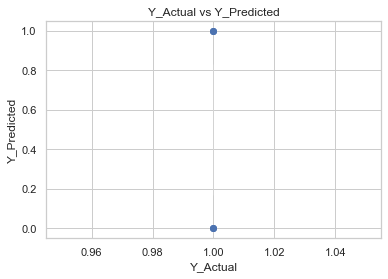

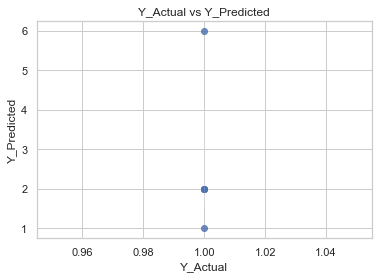

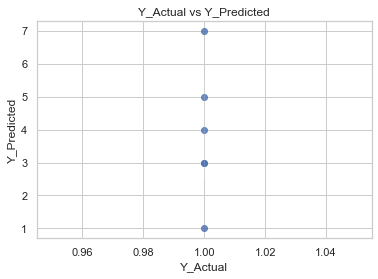

In [330]:
y_actual = [1, 1, 1, 1, 1, 1]
y_test = [1, 1, 1, 0, 0, 0]
assert plot(y_actual, y_test) == True

y_test2 = [2, 2, 2, 1, 6, 2]
assert plot(y_actual, y_test2) == True

y_test3 = [3, 5, 3, 4, 7, 1]
assert plot(y_actual, y_test3) == True

## Problem 1: kNN

Implement k Nearest Neighbors with k = 9.

<a id="knn"></a>
## knn

`knn` the k-nearest neighbor algorithm first starts off by splitting the entire data into fold then those folds will go through cross validation by being split into testing anf training folds. The k-nearest algorithm makes predictions by first retrieve the k nearest neighbors from the test row based on the euclidean distance. From all those nearest neighbors the mean of their y-values is then used at the predictive value for y.  **Uses**: [create_folds](#create_folds), [create_train_test](#create_train_test), [nearest_neighbors](#nearest_neighbors), [calc_mse](#calc_mse), [plot](#plot)

* **data** list[list]: the entire population that is then going to be processed into folds 

* **num_folds** int : the number of folds that the entire population is going to be subdivded into for cross-validation

* **k** int: the amount of nearest neighbors that is going to be generated from the test-row to then make a prediction

**returns** float: returns the mean square error between the predicted values and the actual values generated from the knn algorithm. 

In [331]:
def knn(data: list[list], num_folds: int, k: int)-> float:
    folds = create_folds(data, num_folds)
    all_mse = []
    for index in range(len(folds)):
        train, test = create_train_test(folds, index)
        print("Fold {}: ".format(index+1))
        y_actual = [x[-1] for x in test]
        predictions = []
        for test_row in test: 
            neighbors = nearest_neighbors(train, test_row, k)
            distances = []
            y_pred = sum([x[-1] for x in neighbors]) / k
            predictions.append(y_pred)
        mse = calc_mse(y_actual, predictions)
        all_mse.append(mse)
        plot(y_actual, predictions)
        print('MSE: ', mse, 'RMSE: {}'.format(np.sqrt(mse)), '\n')
        
    return np.mean(all_mse)

Fold 1: 


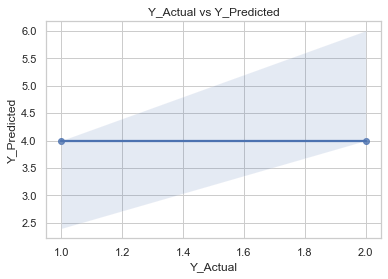

MSE:  6.5 RMSE: 2.5495097567963922 

Fold 2: 


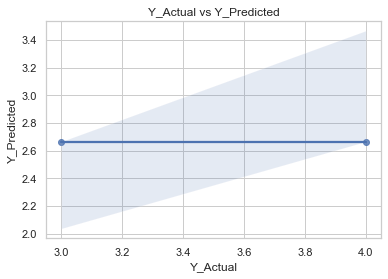

MSE:  0.9444444444444446 RMSE: 0.9718253158075502 

Fold 3: 


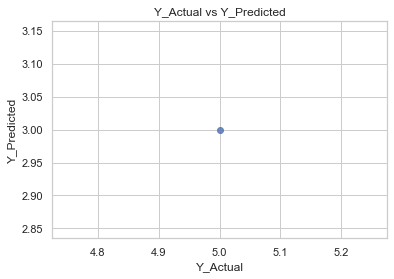

MSE:  4.0 RMSE: 2.0 

Fold 1: 


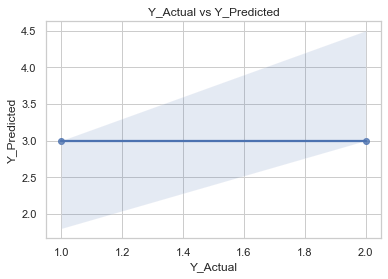

MSE:  2.5 RMSE: 1.5811388300841898 

Fold 2: 


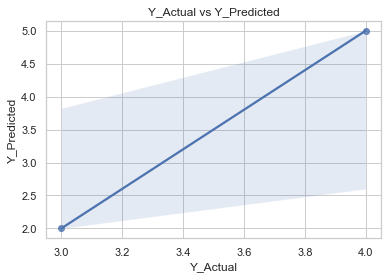

MSE:  1.0 RMSE: 1.0 

Fold 3: 


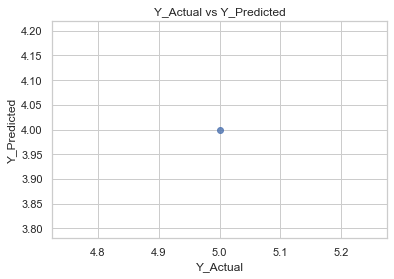

MSE:  1.0 RMSE: 1.0 

Fold 1: 


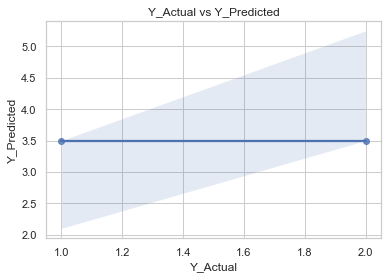

MSE:  4.25 RMSE: 2.0615528128088303 

Fold 2: 


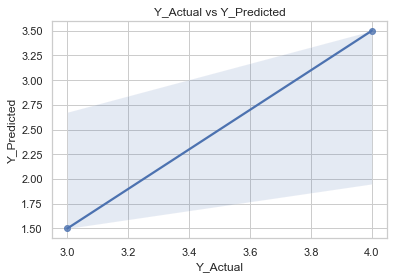

MSE:  1.25 RMSE: 1.118033988749895 

Fold 3: 


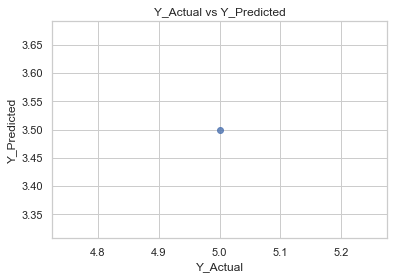

MSE:  2.25 RMSE: 1.5 



In [332]:
test_data = [[1,1,1],
       [2,2,2],
       [3,3,3],
       [4,4,4],
       [5,5,5]]

assert knn(test_data, 3, 3) == 3.814814814814815

assert knn(test_data, 3, 1) == 1.5

assert knn(test_data, 3, 2) ==  2.5833333333333335

### Problem 1 Results:

Fold 1: 


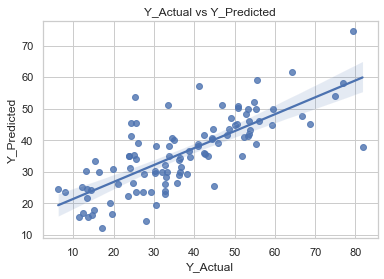

MSE:  120.03669478604819 RMSE: 10.956125902254326 

Fold 2: 


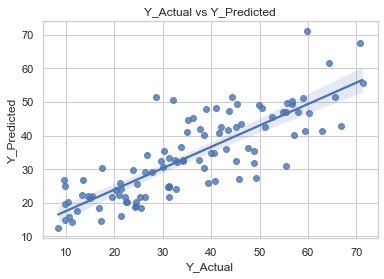

MSE:  89.66104134004554 RMSE: 9.468951438255745 

Fold 3: 


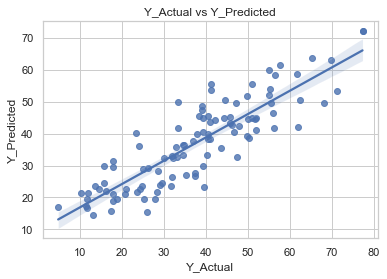

MSE:  63.53398721083543 RMSE: 7.970820987253159 

Fold 4: 


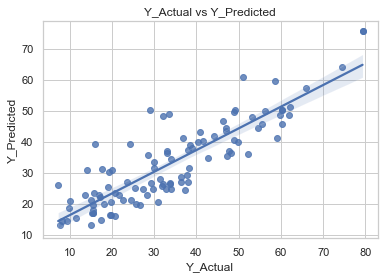

MSE:  71.37214407287547 RMSE: 8.4482036003446 

Fold 5: 


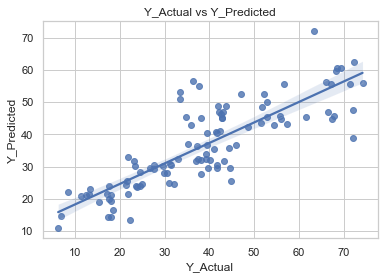

MSE:  96.08386672659714 RMSE: 9.802237842788612 

Fold 6: 


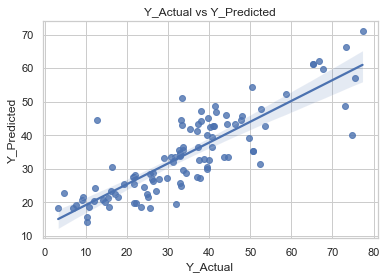

MSE:  84.52155246314274 RMSE: 9.193560380132539 

Fold 7: 


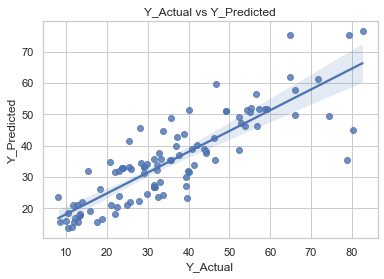

MSE:  91.86878252427188 RMSE: 9.584820422119128 

Fold 8: 


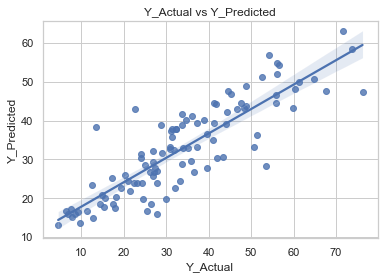

MSE:  73.56829333573054 RMSE: 8.577196123193788 

Fold 9: 


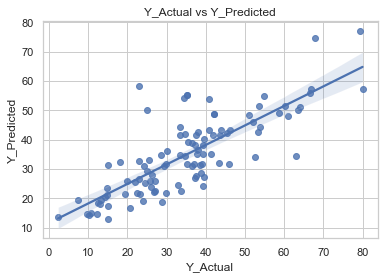

MSE:  93.86955487234808 RMSE: 9.688630185549869 

Fold 10: 


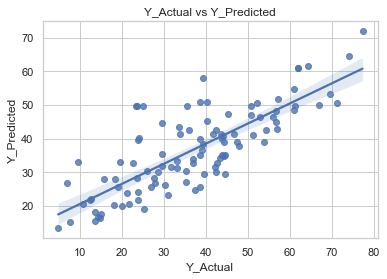

MSE:  98.87824256262735 RMSE: 9.943753947208638 



In [333]:
avg_mse = knn(data, 10, 9)

In [334]:
print('K=9 Average Fold Performance:\n')
print('Average MSE: ', avg_mse, 'Average RMSE: {}'.format(np.sqrt(avg_mse)), '\n')

K=9 Average Fold Performance:

Average MSE:  88.33941598945223 Average RMSE: 9.3989050420489 



## Problem 2: Evaluation vs. The Mean

Using Mean Squared Error (MSE) as your evaluation metric, evaluate your implement above and the Null model, the mean.

<a id="baseline_model"></a>
## baseline_model

`baseline_model` the baseline model starts off by first separting the population into n folds then those folds are separated into training and testing sets. The goal of the baseline model is that for each fold the training dataset's mean will be the predictive value for each test_row in the testing set  **Uses**: [create_folds](#create_folds), [create_train_test](#create_train_test), [calc_mse](#calc_mse), [plot](#plot)

* **data** list[list]: the entire population that is then going to be processed into folds 

* **num_folds** int : the number of folds that the entire population is going to be subdivded into for cross-validation

**returns** float: returns the mean square error between the predicted values and the actual values generated from the knn algorithm. 

In [335]:
def baseline_model(data, num_folds):
    folds = create_folds(data, num_folds)
    fold_mse = []
    for index in range(len(folds)):
        train, test = create_train_test(folds, index)
        print("Fold {}: ".format(index+1))
        y_actual = [x[-1] for x in test]
        mean_y_actual = sum(y_actual)/len(y_actual)
        predictions = [mean_y_actual for x in y_actual]
        mse = calc_mse(y_actual, predictions)
        plot(y_actual, predictions)
        print('Mean Y_Actual: ', mean_y_actual)
        print('MSE: ', mse, 'RMSE: {}'.format(np.sqrt(mse)), '\n')
        fold_mse.append(mse)
    return np.mean(fold_mse)

Fold 1: 


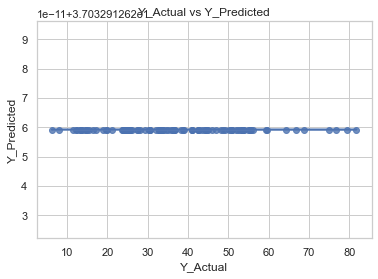

Mean Y_Actual:  37.03291262135924
MSE:  276.0712303515882 RMSE: 16.615391369197063 

Fold 2: 


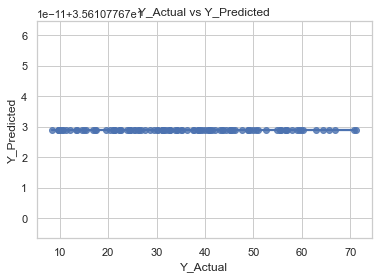

Mean Y_Actual:  35.61077669902911
MSE:  259.23777803751534 RMSE: 16.100862648861874 

Fold 3: 


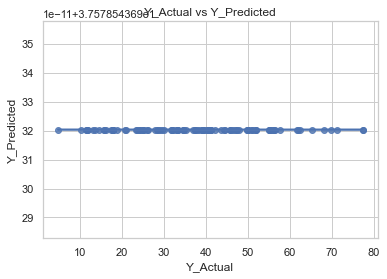

Mean Y_Actual:  37.578543689320384
MSE:  257.7036473937223 RMSE: 16.053150699900698 

Fold 4: 


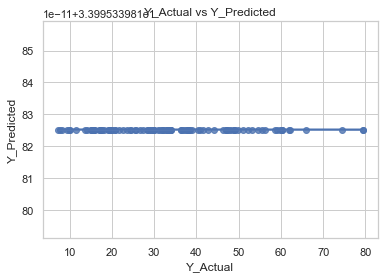

Mean Y_Actual:  33.99533980582525
MSE:  284.31121711754173 RMSE: 16.861530687263887 

Fold 5: 


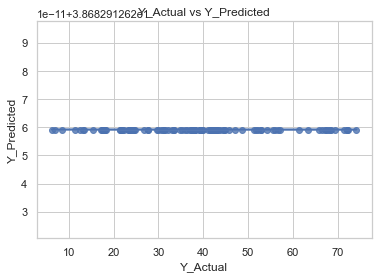

Mean Y_Actual:  38.68291262135922
MSE:  291.82612549721927 RMSE: 17.08291911522206 

Fold 6: 


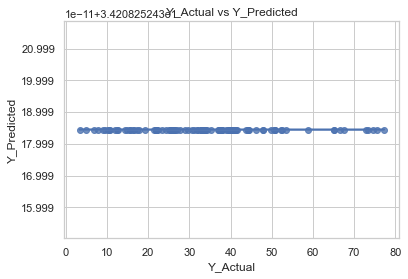

Mean Y_Actual:  34.20825242718448
MSE:  280.2502532566689 RMSE: 16.740676606895818 

Fold 7: 


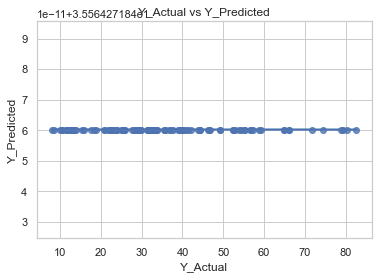

Mean Y_Actual:  35.564271844660205
MSE:  329.1748924309548 RMSE: 18.14317757260163 

Fold 8: 


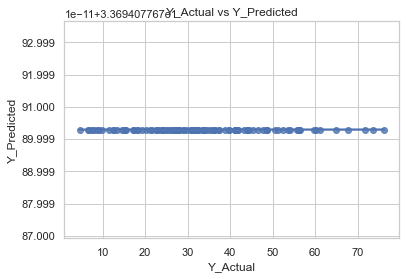

Mean Y_Actual:  33.69407766990292
MSE:  264.15442609105475 RMSE: 16.252828248986535 

Fold 9: 


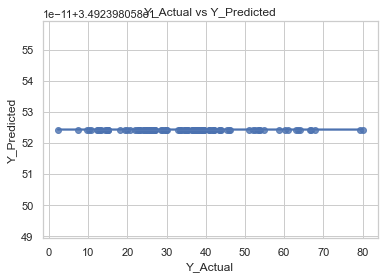

Mean Y_Actual:  34.923980582524294
MSE:  252.0613521161278 RMSE: 15.876440158805368 

Fold 10: 


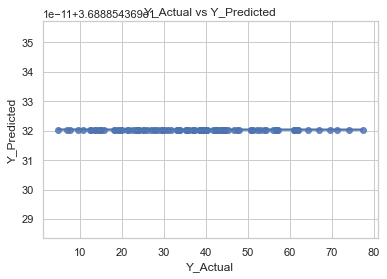

Mean Y_Actual:  36.88854368932039
MSE:  268.0573619568291 RMSE: 16.372457419606537 



In [336]:
avg_baseline_mse = baseline_model(data, 10)

In [337]:
print('Null Model Average Fold Performance:\n')
print('Average MSE: ', avg_baseline_mse, 'Average RMSE: {}'.format(np.sqrt(avg_baseline_mse), '\n'))

Null Model Average Fold Performance:

Average MSE:  276.2848284249222 Average RMSE: 16.621817843573012


## Problem 3: Hyperparameter Tuning
Tune the value of k.

## tune

`tune` the baseline model starts off by first separting the population into n folds then those folds are separated into training and testing sets. The goal of the baseline model is that for each fold the training dataset's mean will be the predictive value for each test_row in the testing set  **Uses**: [create_folds](#create_folds), [create_train_test](#create_train_test), [calc_mse](#calc_mse), [plot](#plot), [knn](#knn)

* **data** list[list]: the entire population that is then going to be processed into folds 

* **algo** str: the algorithm that tuning is going ot be performed on

* **num_folds** int : the number of folds that the entire population is going to be subdivded into for cross-validation

* **hyperparameter_values** list[int]: list of integers that are going to be tuned for the value of K


**returns** float: returns the mean square error between the predicted values and the actual values generated from the knn algorithm. 

In [338]:
def tune(data, algo, num_folds, hyperparameter_values):
    metrics = []
    for value in hyperparameter_values:
        print('Hyperparameter Value: ', value)
        avg_metric = algo(data, num_folds, value)
        metrics.append(avg_metric)
    return metrics

Hyperparameter Value:  1
Fold 1: 


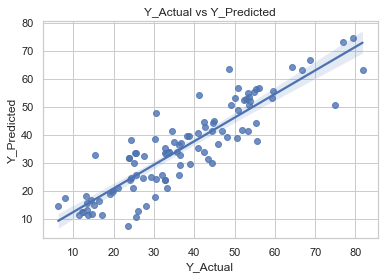

MSE:  60.04470873786409 RMSE: 7.7488520916239 

Fold 2: 


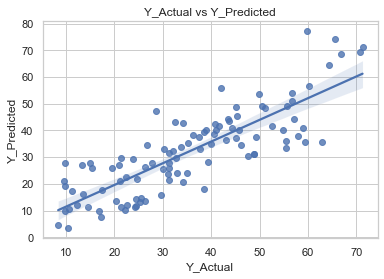

MSE:  98.71490970873784 RMSE: 9.935537716134837 

Fold 3: 


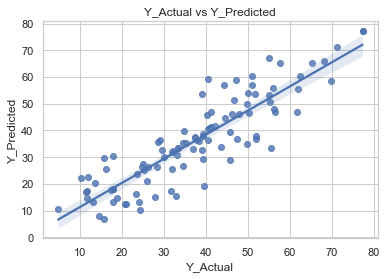

MSE:  63.95625825242717 RMSE: 7.9972656734928576 

Fold 4: 


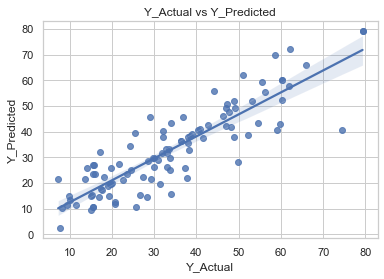

MSE:  70.78293883495144 RMSE: 8.413259703286915 

Fold 5: 


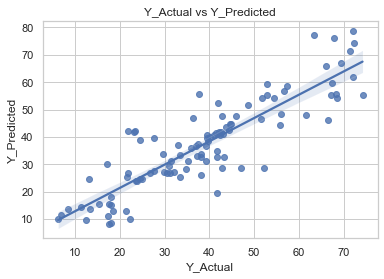

MSE:  72.94408349514565 RMSE: 8.540730852517578 

Fold 6: 


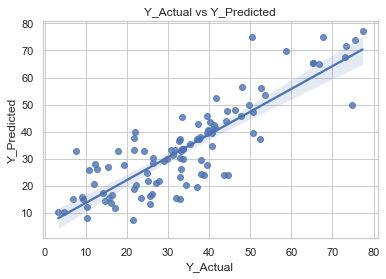

MSE:  83.10024563106795 RMSE: 9.115933612695297 

Fold 7: 


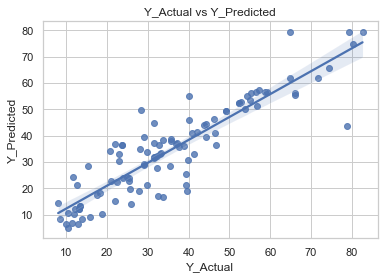

MSE:  66.97009999999999 RMSE: 8.18352613486387 

Fold 8: 


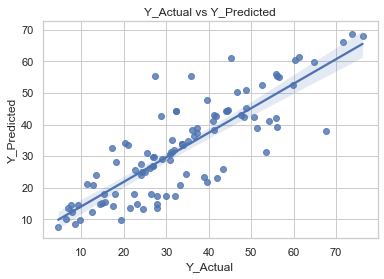

MSE:  82.94284077669901 RMSE: 9.107296018945416 

Fold 9: 


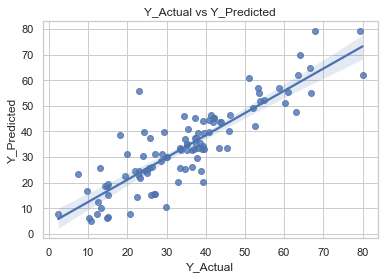

MSE:  68.14862912621358 RMSE: 8.255218296702612 

Fold 10: 


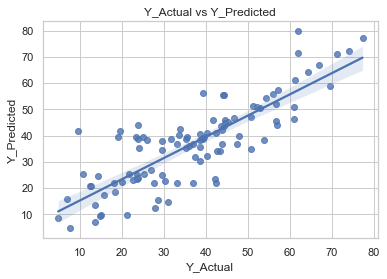

MSE:  88.90243009708736 RMSE: 9.428808519483646 

Hyperparameter Value:  3
Fold 1: 


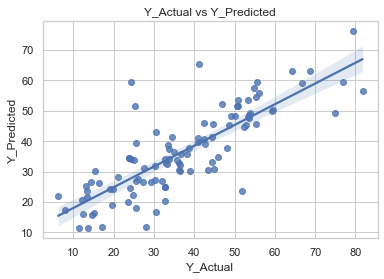

MSE:  93.05681866235167 RMSE: 9.646596221587782 

Fold 2: 


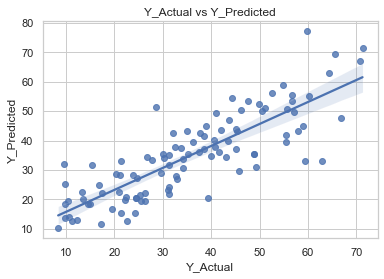

MSE:  82.06517216828479 RMSE: 9.058982954409661 

Fold 3: 


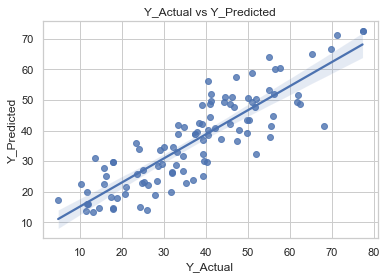

MSE:  66.48816084142395 RMSE: 8.15402727745155 

Fold 4: 


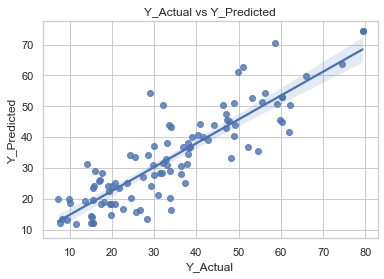

MSE:  69.46968834951456 RMSE: 8.334847830015528 

Fold 5: 


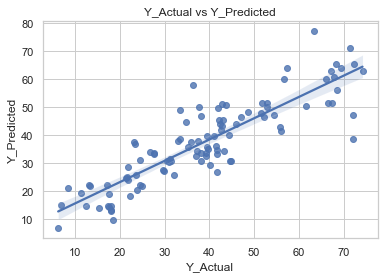

MSE:  71.31855620280473 RMSE: 8.445031450669958 

Fold 6: 


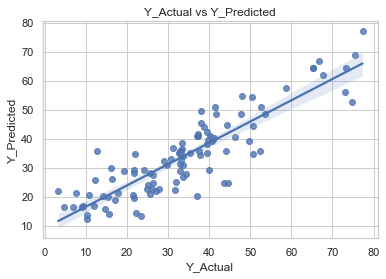

MSE:  62.67876138079827 RMSE: 7.916991940175149 

Fold 7: 


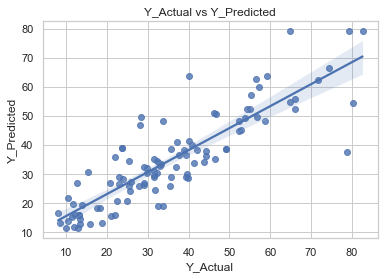

MSE:  83.44412308522115 RMSE: 9.134775480832637 

Fold 8: 


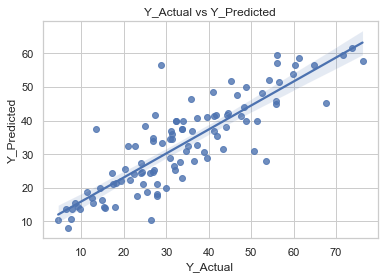

MSE:  71.41801359223302 RMSE: 8.450917914181455 

Fold 9: 


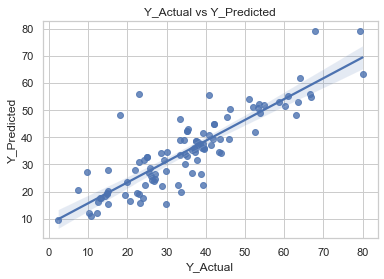

MSE:  65.87383861920172 RMSE: 8.11626999422775 

Fold 10: 


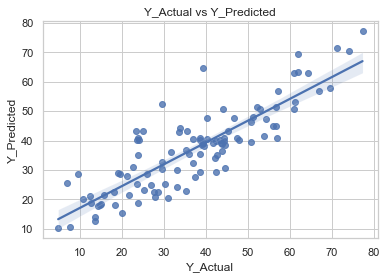

MSE:  72.96265803667747 RMSE: 8.541818192672885 

Hyperparameter Value:  5
Fold 1: 


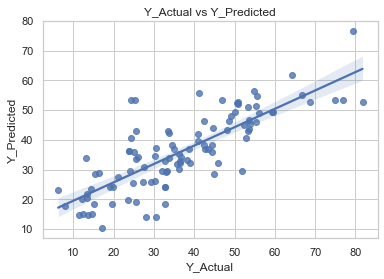

MSE:  100.32439615533983 RMSE: 10.016206674951343 

Fold 2: 


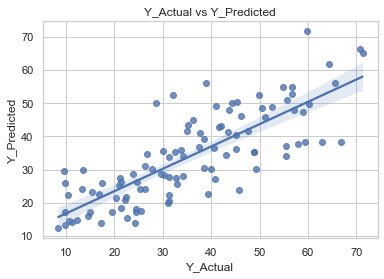

MSE:  96.14072442718445 RMSE: 9.805137654678003 

Fold 3: 


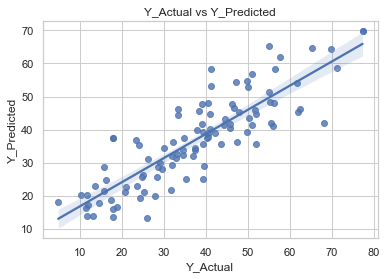

MSE:  67.52548912621359 RMSE: 8.217389434985638 

Fold 4: 


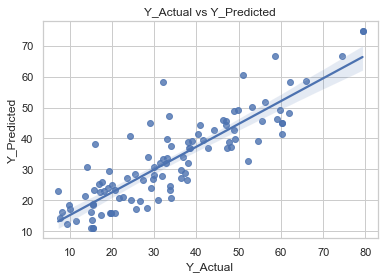

MSE:  72.10129805825242 RMSE: 8.491248321551573 

Fold 5: 


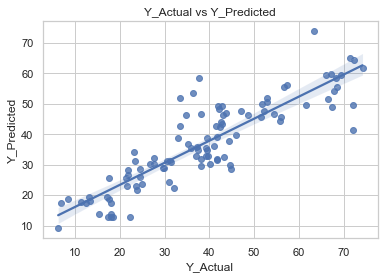

MSE:  71.7572082330097 RMSE: 8.470962650903951 

Fold 6: 


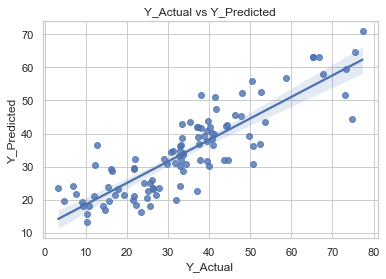

MSE:  76.90138737864079 RMSE: 8.769343611618876 

Fold 7: 


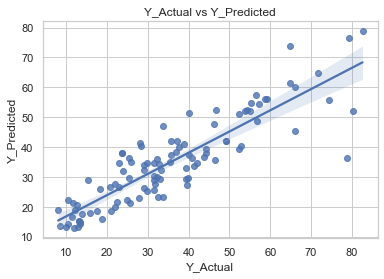

MSE:  75.40413363106795 RMSE: 8.68355535659605 

Fold 8: 


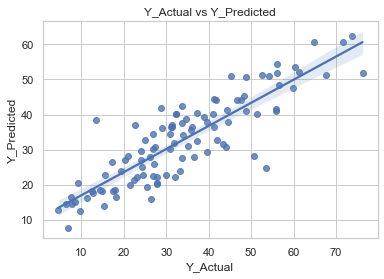

MSE:  69.86808512621359 RMSE: 8.358713126206306 

Fold 9: 


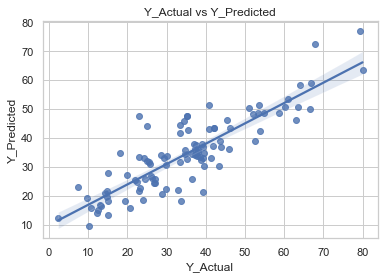

MSE:  65.49392023300972 RMSE: 8.092831410143777 

Fold 10: 


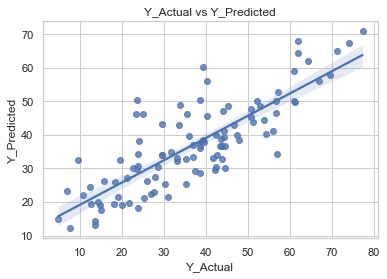

MSE:  87.68288613592233 RMSE: 9.36391403932791 

Hyperparameter Value:  7
Fold 1: 


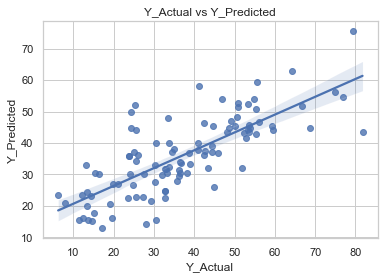

MSE:  115.45741230433921 RMSE: 10.745111088506215 

Fold 2: 


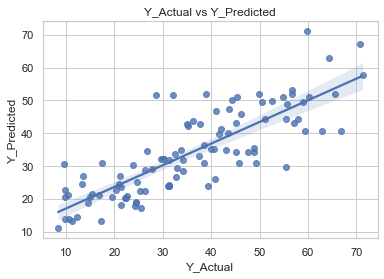

MSE:  87.71892013077077 RMSE: 9.365837929986338 

Fold 3: 


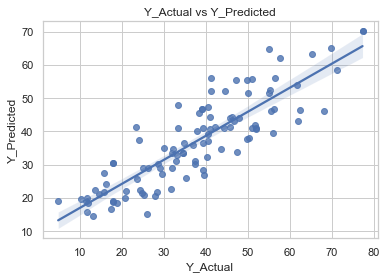

MSE:  65.01236235387358 RMSE: 8.06302439248906 

Fold 4: 


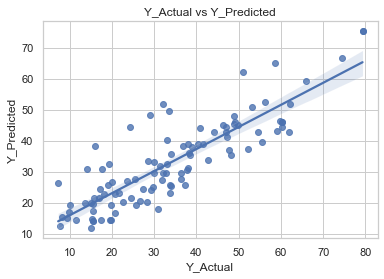

MSE:  74.60634032098275 RMSE: 8.637496183558216 

Fold 5: 


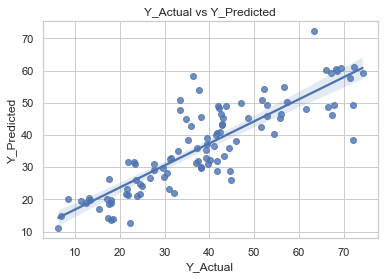

MSE:  84.29492516346343 RMSE: 9.181226778784163 

Fold 6: 


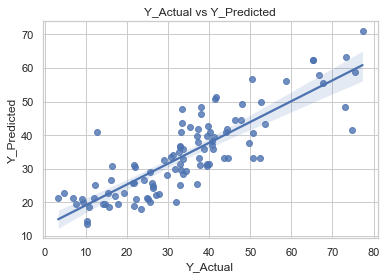

MSE:  83.38221602932435 RMSE: 9.131386314756613 

Fold 7: 


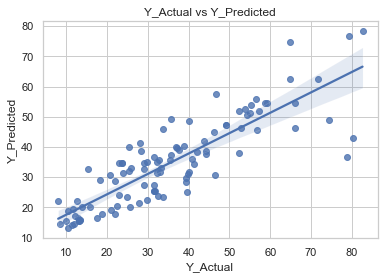

MSE:  90.81183271250251 RMSE: 9.52952426475228 

Fold 8: 


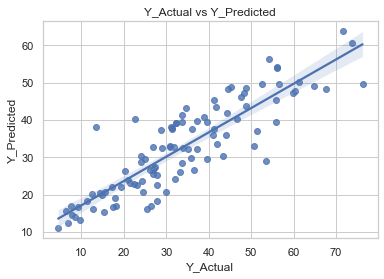

MSE:  68.23406457301368 RMSE: 8.260391308710119 

Fold 9: 


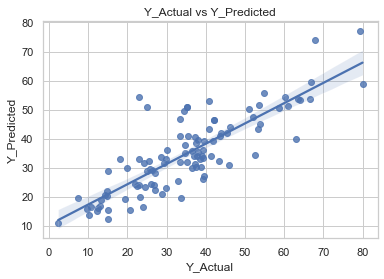

MSE:  77.66091957598574 RMSE: 8.812543309169365 

Fold 10: 


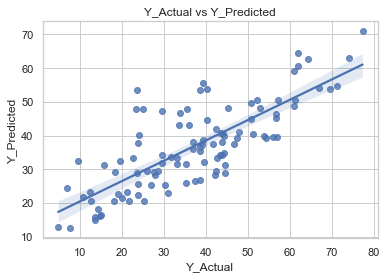

MSE:  101.93666235387363 RMSE: 10.096368770695415 

Hyperparameter Value:  9
Fold 1: 


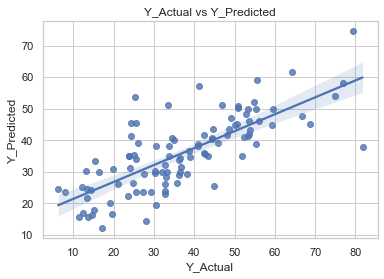

MSE:  120.03669478604819 RMSE: 10.956125902254326 

Fold 2: 


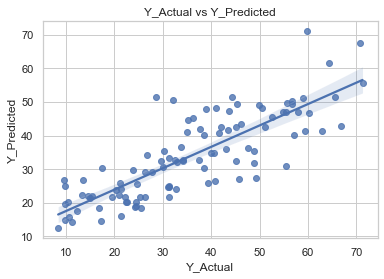

MSE:  89.66104134004554 RMSE: 9.468951438255745 

Fold 3: 


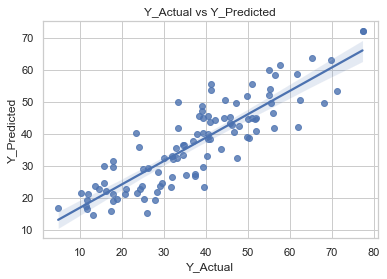

MSE:  63.53398721083543 RMSE: 7.970820987253159 

Fold 4: 


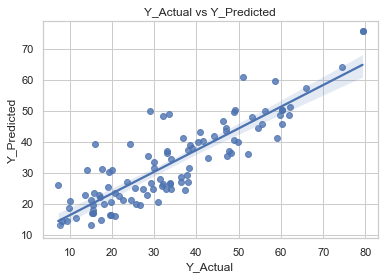

MSE:  71.37214407287547 RMSE: 8.4482036003446 

Fold 5: 


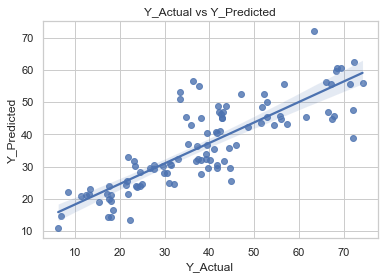

MSE:  96.08386672659714 RMSE: 9.802237842788612 

Fold 6: 


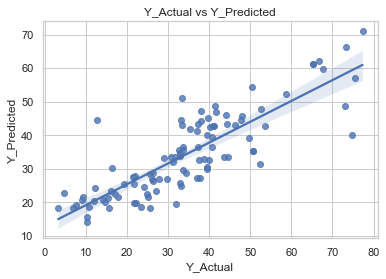

MSE:  84.52155246314274 RMSE: 9.193560380132539 

Fold 7: 


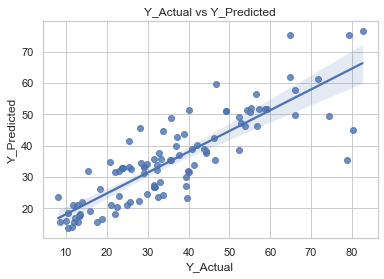

MSE:  91.86878252427188 RMSE: 9.584820422119128 

Fold 8: 


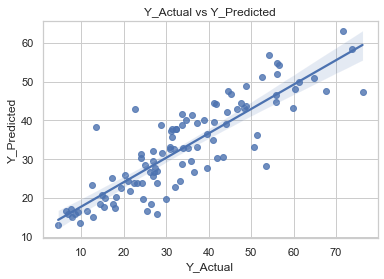

MSE:  73.56829333573054 RMSE: 8.577196123193788 

Fold 9: 


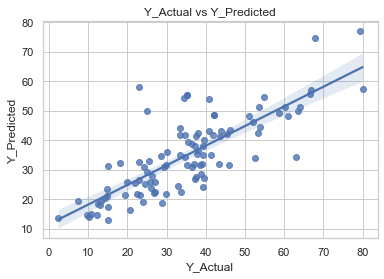

MSE:  93.86955487234808 RMSE: 9.688630185549869 

Fold 10: 


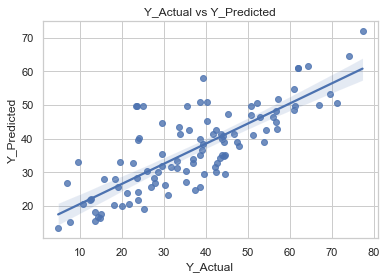

MSE:  98.87824256262735 RMSE: 9.943753947208638 

Hyperparameter Value:  11
Fold 1: 


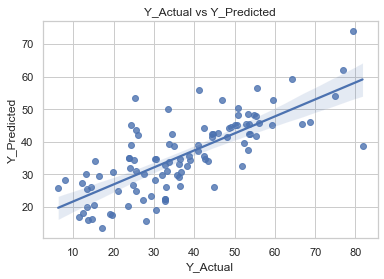

MSE:  123.21174632913426 RMSE: 11.100078663195783 

Fold 2: 


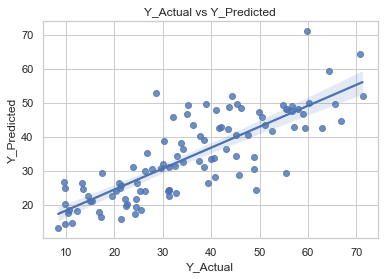

MSE:  93.64560930755036 RMSE: 9.677066151863919 

Fold 3: 


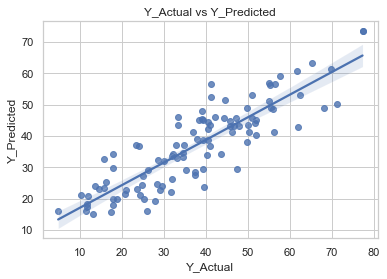

MSE:  63.75872090186954 RMSE: 7.984905816718788 

Fold 4: 


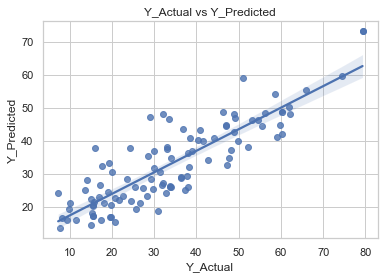

MSE:  75.80556517692371 RMSE: 8.706639143603214 

Fold 5: 


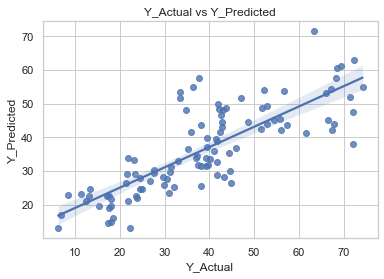

MSE:  108.34852591671347 RMSE: 10.409059799843282 

Fold 6: 


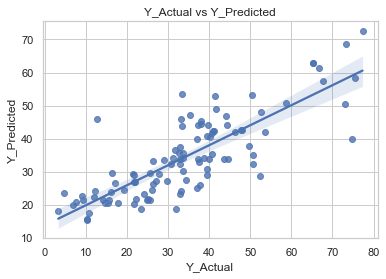

MSE:  94.97047789456794 RMSE: 9.745279775079212 

Fold 7: 


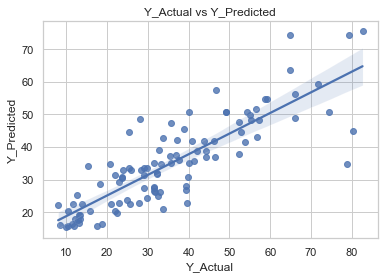

MSE:  98.87690990933162 RMSE: 9.9436869374157 

Fold 8: 


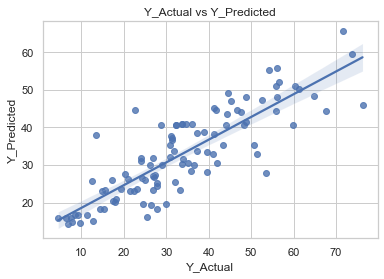

MSE:  80.19379536227231 RMSE: 8.955098847152515 

Fold 9: 


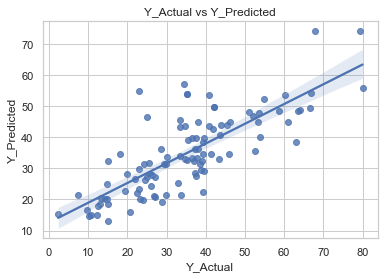

MSE:  96.32987131509269 RMSE: 9.814778210183492 

Fold 10: 


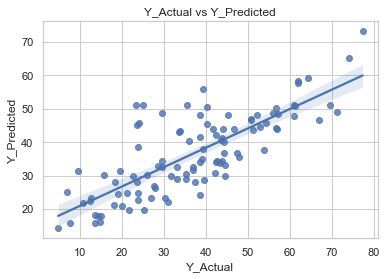

MSE:  103.15798466661319 RMSE: 10.156671928669017 

Hyperparameter Value:  13
Fold 1: 


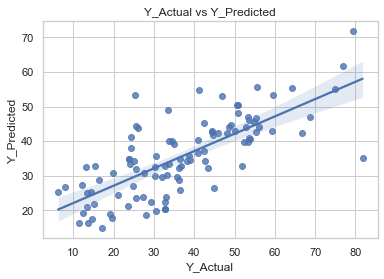

MSE:  127.67627415407595 RMSE: 11.299392645362667 

Fold 2: 


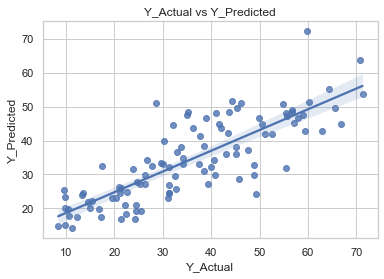

MSE:  90.56076603090712 RMSE: 9.516342050961972 

Fold 3: 


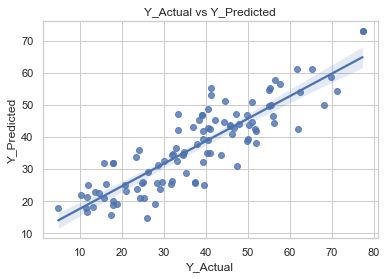

MSE:  62.87606539323261 RMSE: 7.929442943437616 

Fold 4: 


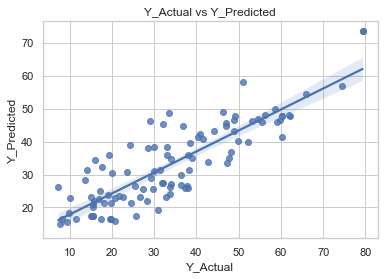

MSE:  79.76498620669845 RMSE: 8.931124576821132 

Fold 5: 


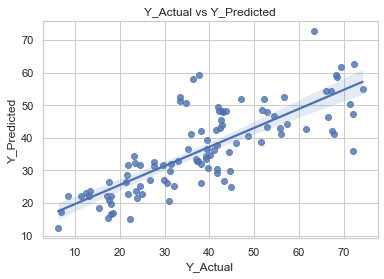

MSE:  116.61170693973692 RMSE: 10.79869005665673 

Fold 6: 


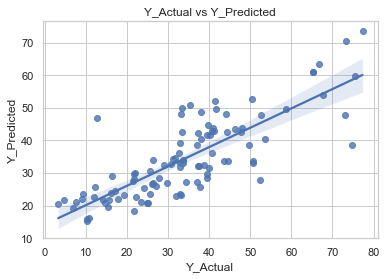

MSE:  99.09651150686507 RMSE: 9.954723075347957 

Fold 7: 


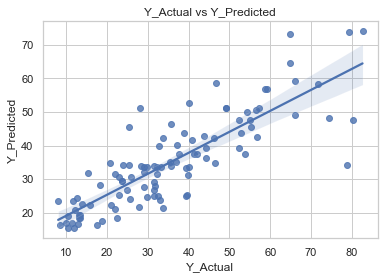

MSE:  100.97912103176881 RMSE: 10.048836799937035 

Fold 8: 


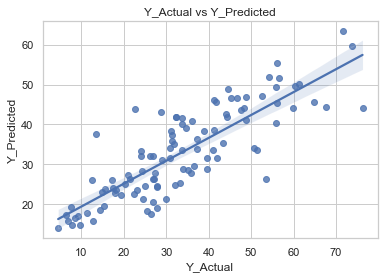

MSE:  86.74931233411846 RMSE: 9.313931089186696 

Fold 9: 


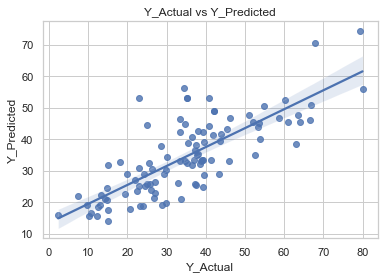

MSE:  99.67608747630265 RMSE: 9.983791237616233 

Fold 10: 


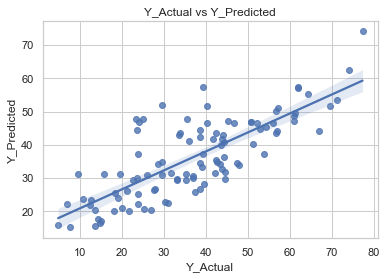

MSE:  104.1551195438617 RMSE: 10.205641554741264 

Hyperparameter Value:  15
Fold 1: 


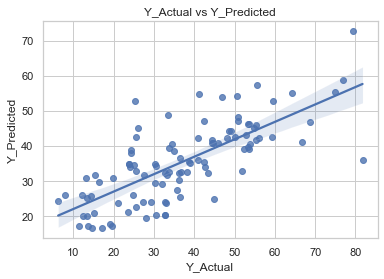

MSE:  128.7871294455232 RMSE: 11.348441718823038 

Fold 2: 


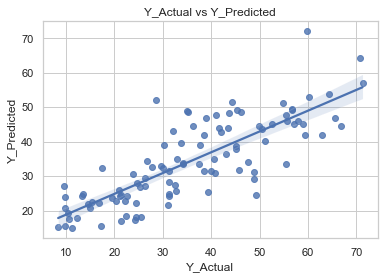

MSE:  93.18604349514565 RMSE: 9.65329184761062 

Fold 3: 


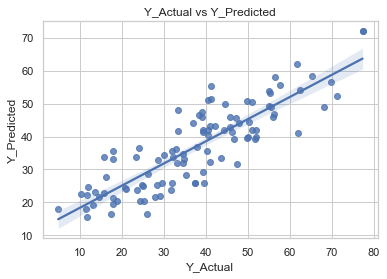

MSE:  70.07434536353828 RMSE: 8.371042071542723 

Fold 4: 


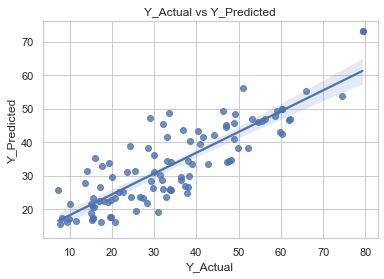

MSE:  82.38041654368934 RMSE: 9.076365822491365 

Fold 5: 


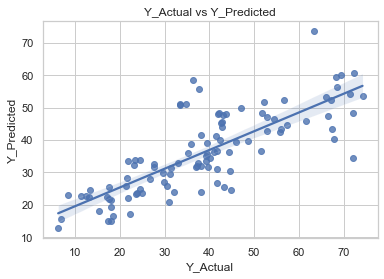

MSE:  116.4906364314995 RMSE: 10.793082804810657 

Fold 6: 


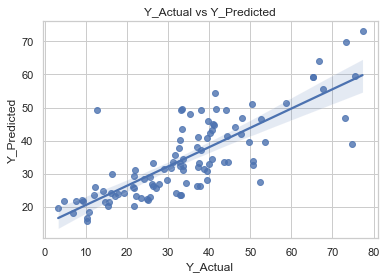

MSE:  102.07896816828479 RMSE: 10.103413688862037 

Fold 7: 


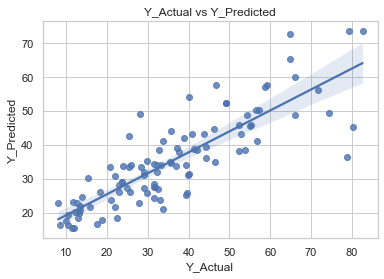

MSE:  98.54945197411006 RMSE: 9.927207662485461 

Fold 8: 


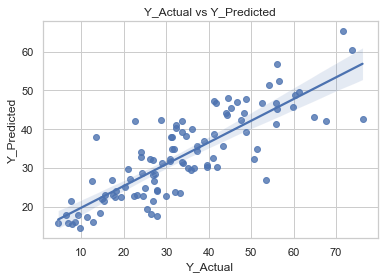

MSE:  90.30243910248113 RMSE: 9.502759551966005 

Fold 9: 


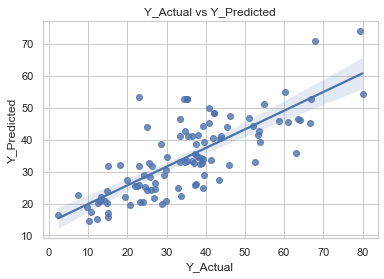

MSE:  101.05275240992451 RMSE: 10.052499808998979 

Fold 10: 


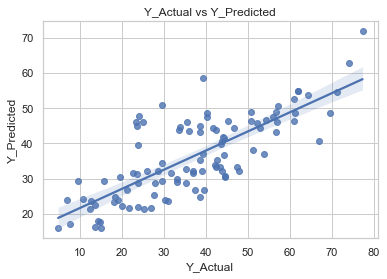

MSE:  108.88509810140239 RMSE: 10.434802255021529 



In [339]:
k_values = [1,3,5,7,9,11,13,15]

tuning_mse = tune(data, knn, 10, k_values)
tuning_rmse = [np.sqrt(x) for x in tuning_mse]

### Problem 3 Evaluation Results:

In [340]:
def plot2(hyperparameters, results):
    rmse = [np.sqrt(x) for x in results]
    fig, ax = plt.subplots(1,2)
    sns.lineplot(x = hyperparameters, y = results, ax=ax[0])
    sns.lineplot(x = hyperparameters, y = rmse, ax=ax[1])
    ax[0].title.set_text('MSE vs. K-Value')
    ax[1].title.set_text('RMSE vs. K - Value')
    for i in range(len(hyperparameters)):
        print('K - Value : {} , Average MSE : {} , Average RMSE : {} '.format(hyperparameters[i],
                                                               results[i], rmse[i]))
    return

K - Value : 1 , Average MSE : 75.65071446601941 , Average RMSE : 8.697741917648477 
K - Value : 3 , Average MSE : 73.87757909385112 , Average RMSE : 8.595206751082323 
K - Value : 5 , Average MSE : 78.31995285048544 , Average RMSE : 8.849856092077736 
K - Value : 7 , Average MSE : 84.91156555181297 , Average RMSE : 9.214747177856426 
K - Value : 9 , Average MSE : 88.33941598945223 , Average RMSE : 9.3989050420489 
K - Value : 11 , Average MSE : 93.82992067800691 , Average RMSE : 9.686584572387055 
K - Value : 13 , Average MSE : 96.81459506175676 , Average RMSE : 9.83944079009355 
K - Value : 15 , Average MSE : 99.17872810355989 , Average RMSE : 9.958851746238613 


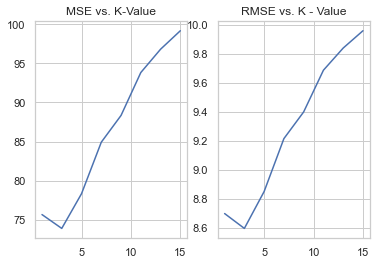

In [341]:
plot2(k_values, tuning_mse)

## Problem 4: Generalization Error
Analyze and discuss the generalization error of your model with the value of k from Problem 3.

### It appears from tuning the hyperparameter K, that at K=3 that appears to be the optimal point where it lies between being under-fitted and over-fitted. After that it appears the the mse increases in direct proportion with the number of K. It therefore seems that when K is higher then 3 that the model is being overfitted and not be able to be generalizable. 

## Q5: Choose your own adventure

You have three options for the next part:

1. You can implement mean normalization (also called "z-score standardization") of the *features*; do not normalize the target, y. See if this improves the generalization error of your model (middle).

2. You can implement *learning curves* to see if more data would likely improve your model (easiest).

3. You can implement *weighted* kNN and use the real valued GA to choose the weights. weighted kNN assigns a weight to each item in the Euclidean distance calculation. For two points, j and k:
$$\sqrt{\sum w_i (x^k_i - x^j_i)^2}$$

You can think of normal Euclidean distance as the case where $w_i = 1$ for all features  (ambitious, but fun...you need to start EARLY because it takes a really long time to run).

The easier the adventure the more correct it must be...

## Gaussian Kernel

`Gaussian kernel` The gaussian kernel is one method in which the weight attribute can be attributed to the nearest neighbors. Gaussian kernel uses distances and bandwidth to return a list of weights.   **Used by**: [weight_knn] (#weight_knn)

kernel with distance > 1. It is defined ad c_qNNj(weight) = Kernel_lambda(distance(x_NNj, x_q))

* **distance** list: list of the distances between the points in the sample and the query point. 

* **bandwidth** int: length of the bandwidth

**returns** list: 

In [350]:
def gaussian_kernel (distances: list, bandwidth: int) -> list:
    weights = []
    for i in range(len(distances)):
        u = distances[i]/bandwidth
        kernel = (((2 * math.pi) ** 0.5) ** -1) * (math.exp(((-u ** 2) / 2))) +1
        weights.append(kernel)
    return weights

In [351]:
test_data = [1,2,3,4,5,6,7,8]

assert gaussian_kernel(test_data, 2) == [1.3520653267642995, 1.2419707245191434, 1.1295175956658918, 1.0539909665131881,
                                         1.0175283004935685, 1.004431848411938, 1.0008726826950458, 1.000133830225765]

assert gaussian_kernel(test_data, 5) == [1.3910426939754559, 1.3682701403033233, 1.3332246028917996, 1.2896915527614827,
                                         1.2419707245191434, 1.1941860549832128, 1.1497274656357448, 1.1109208346794555]

assert gaussian_kernel(test_data, 1) == [1.2419707245191434, 1.0539909665131881, 1.004431848411938, 1.000133830225765,
                                         1.0000014867195148, 1.000000006075883, 1.0000000000091347, 1.000000000000005]

In [352]:
def weight_knn(data: list[list], num_folds: int, k: int, bandwidth: int)-> float:
    folds = create_folds(data, num_folds)
    all_mse = []
    for index in range(len(folds)):
        train, test = create_train_test(folds, index)
        print("Fold {}: ".format(index+1))
        y_actual = [x[-1] for x in test]
        predictions = []
        for test_row in test: 
            neighbors = nearest_neighbors(train, test_row, k)
            distances = []
            for neighbor in neighbors:
                distance = euclidean_distance(neighbor, test_row)
                distances.append(distance)
            weights = gaussian_kernel(distances, bandwidth)
            numerator = []
            for i in range(len(neighbors)):
                product = weights[i] *neighbors[i][-1]
                numerator.append(product)
            prediction = sum(numerator)/sum(weights)
            predictions.append(prediction)
        mse = calc_mse(y_actual, predictions)
        plot(y_actual, predictions)
        print('MSE: ', mse, 'RMSE: {}'.format(np.sqrt(mse)), '\n')
        all_mse.append(mse)
    return np.mean(all_mse)

Fold 1: 


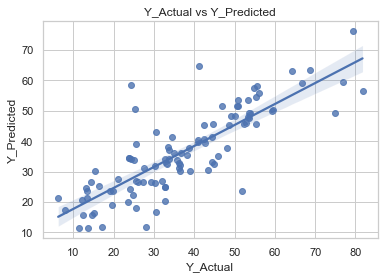

MSE:  89.47810802783677 RMSE: 9.459286866769437 

Fold 2: 


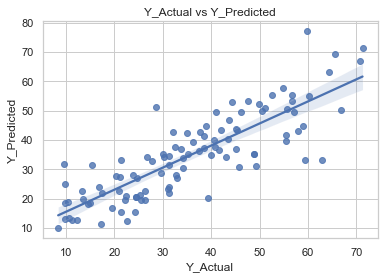

MSE:  79.12725113578932 RMSE: 8.89534997264241 

Fold 3: 


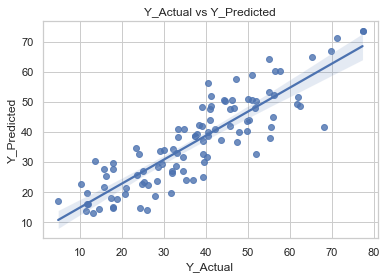

MSE:  63.09130549634486 RMSE: 7.943003556359827 

Fold 4: 


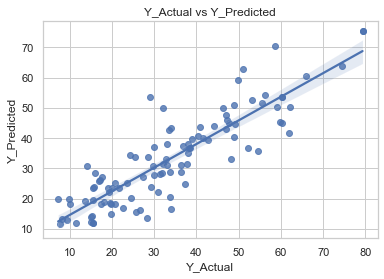

MSE:  66.68827431161422 RMSE: 8.166288894694715 

Fold 5: 


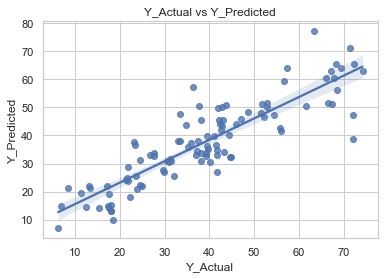

MSE:  68.45260272282619 RMSE: 8.273608808907161 

Fold 6: 


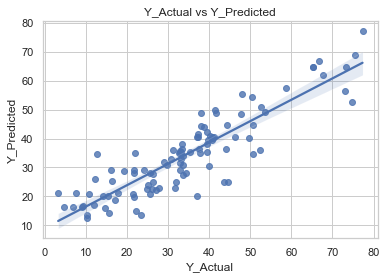

MSE:  59.824971533755175 RMSE: 7.734660401966926 

Fold 7: 


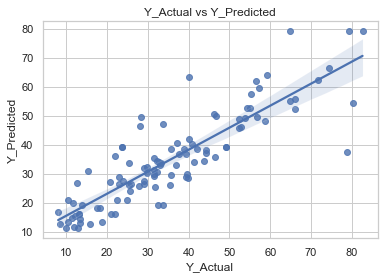

MSE:  80.80748045205242 RMSE: 8.989298106751852 

Fold 8: 


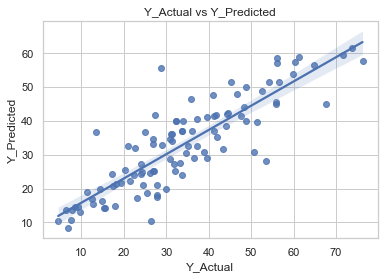

MSE:  69.0338351151211 RMSE: 8.30866024790526 

Fold 9: 


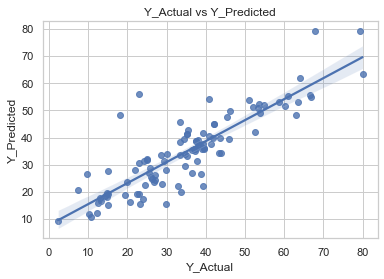

MSE:  63.87583454056922 RMSE: 7.992235891198984 

Fold 10: 


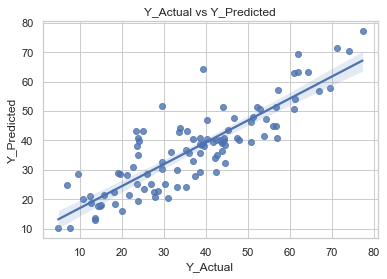

MSE:  70.19566638746848 RMSE: 8.378285408570687 



In [353]:
avg_weighted_mse = weight_knn(data, 10, 3, 3)

In [354]:
print('K=3 Average Fold Performance:\n')
print('Average Weighted MSE: ', avg_weighted_mse, 'Average Weighted RMSE: {}'.format(np.sqrt(avg_weighted_mse)), '\n')

K=3 Average Fold Performance:

Average Weighted MSE:  71.05753297233778 Average Weighted RMSE: 8.429563035670222 



With the Weighted KNN using the gaussian kernel, the average weighted mse and rmse are lower than it's counterpart without. 

## Before You Submit...

1. Did you provide output exactly as requested?
2. Did you re-execute the entire notebook? ("Restart Kernel and Rull All Cells...")
3. If you did not complete the assignment or had difficulty please explain what gave you the most difficulty in the Markdown cell below.
4. Did you change the name of the file to `jhed_id.ipynb`?

Do not submit any other files.